## Sarah Scolnik - Capstone: Airbnb

### Data source

http://insideairbnb.com/get-the-data.html  
Inside Airbnb scraped data for Washington DC on these dates:
- 11/15/18
- 10/12/18
- 9/14/18
- 8/18/18
- 7/20/18
- 5/18/18
- 4/15/18
- 5/10/17
- 3/10/17
- 10/3/15

Calendar/price data starts on date scraped

### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

### functions

In [2]:
# clean price: turn non-null prices from string to float

def clean_price(df_clean):
    df_clean['price'] = df_clean['price'].map(lambda s: s.strip('$') if (type(s) is str) else s) # if checks for NaNs
    df_clean['price'] = df_clean['price'].map(lambda s: s.replace(',', '') if (type(s) is str) else s) # if checks for NaNs
    df_clean['price'] = df_clean['price'].astype('float64')


In [3]:
# turn 'zipcode' from float to string

def clean_zipcode(df_clean):
    df_clean['zipcode'] = df_clean['zipcode'].map(lambda x: str(x).split('.')[0])
    df_clean['zipcode'] = df_clean['zipcode'].map(lambda x: str(x).split('-')[0])
    df_clean['zipcode'] = df_clean['zipcode'].replace('nan', np.nan)
    df_clean['zipcode'] = df_clean['zipcode'].replace(r'^\s+$', np.nan, regex=True) # from https://stackoverflow.com/questions/13445241/replacing-blank-values-white-space-with-nan-in-pandas

In [4]:
# set null 'review_scores_rating' to 0 for listings where 'number_of_reviews' == 0]

def clean_review_scores_rating(df_clean):
    filter_noreviews = df_clean['number_of_reviews'] == 0
    df_clean.loc[filter_noreviews, 'review_scores_rating'] = 0

In [5]:
# create variable 'year' and dummy variables 'year_2015' and 'year_2018'

def get_years(df):
    df['year'] = df['scrape_id'].map(lambda s: str(s)[0:4])
    df['year_2015'] = df['year'].map({'2015':1, '2017':0, '2018':0})
    df['year_2018'] = df['year'].map({'2015':0, '2017':0, '2018':1})
 

In [6]:
# create dummy variables 'q_2', 'q_3' and 'q_4'

def get_quarters(df):
    q_2 = {20151002231825:0, 20170310074739:0, 20170510175449:1, 20180415141347:1, 20180518061138:1, 
           20180720044642:0, 20180818154049:0, 20180914083845:0, 20181012035004:0, 20181115100708:0}
    q_3 = {20151002231825:0, 20170310074739:0, 20170510175449:0, 20180415141347:0, 20180518061138:0, 
           20180720044642:1, 20180818154049:1, 20180914083845:1, 20181012035004:0, 20181115100708:0}
    q_4 = {20151002231825:1, 20170310074739:0, 20170510175449:0, 20180415141347:0, 20180518061138:0, 
           20180720044642:0, 20180818154049:0, 20180914083845:0, 20181012035004:1, 20181115100708:1}
    df['q_2'] = df['scrape_id'].map(q_2)
    df['q_3'] = df['scrape_id'].map(q_3)
    df['q_4'] = df['scrape_id'].map(q_4)
 

In [7]:
# set categorical variable values that occur less than the threshold frequency to 'other'
# ref: https://stackoverflow.com/questions/35041628/conditionally-create-an-other-category-in-categorical-column

def cat_other(df, col, threshold):
    filter_cat = df[col].value_counts(normalize=True) < threshold
    df.loc[df[col].isin((df[col].value_counts()[filter_cat]).index), col] = 'other'


### import all listing data files

In [8]:
dflist_15Oct = pd.read_csv('../data/2015-10/2015-10-listings.csv')
dflist_17Mar = pd.read_csv('../data/2017-03/2017-03-listings.csv')
dflist_17May = pd.read_csv('../data/2017-05/2017-05-listings.csv')
dflist_18Apr = pd.read_csv('../data/2018-04/2018-04-listings.csv')
dflist_18May = pd.read_csv('../data/2018-05/2018-05-listings.csv')
dflist_18Jul = pd.read_csv('../data/2018-07/2018-07-listings.csv')
dflist_18Aug = pd.read_csv('../data/2018-08/2018-08-listings.csv')
dflist_18Sep = pd.read_csv('../data/2018-09/2018-09-listings.csv')
dflist_18Oct = pd.read_csv('../data/2018-10/2018-10-listings.csv')
dflist_18Nov = pd.read_csv('../data/2018-11/2018-11-listings.csv')

/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (43,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
dflists_all = [dflist_15Oct, dflist_17Mar, dflist_17May, dflist_18Apr, dflist_18May, dflist_18Jul, dflist_18Aug, dflist_18Sep, 
           dflist_18Oct, dflist_18Nov]

In [10]:
# concatenate listing files into one dataframe

dflist = pd.concat(dflists_all, sort=True)
dflist.shape

(82955, 96)

In [11]:
dflist.head()

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,NaN,4,"{TV,""Wireless Internet"",""Air Conditioning"",Kit...",0,283,0,8,1.0,Real Bed,1.0,...,NaN,NaN,DC,"3rd Street Southeast, Washington, DC 20003, Un...",Professional pictures coming soon! Welcome to ...,https://a2.muscache.com/ac/pictures/105507202/...,NaN,"$1,125.00",https://a2.muscache.com/ac/pictures/105507202/...,20003
1,NaN,6,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",12,343,38,68,3.0,Real Bed,3.0,...,Beautifully renovated Capitol Hill townhouse. ...,NaN,DC,"11th Street Southeast, Washington, DC 20003, U...",NaN,https://a2.muscache.com/ac/pictures/14613245/d...,NaN,NaN,https://a2.muscache.com/ac/pictures/14613245/d...,20003
2,NaN,1,"{""Cable TV"",""Wireless Internet"",""Air Condition...",0,60,30,60,2.0,Real Bed,1.0,...,NaN,NaN,MD,"14th Place, Hyattsville, MD 20782, United States",This is an ideal room for a single traveler th...,https://a1.muscache.com/ac/pictures/104989386/...,NaN,$300.00,https://a1.muscache.com/ac/pictures/104989386/...,20782
3,NaN,2,"{TV,Internet,""Wireless Internet"",""Air Conditio...",30,365,60,90,1.0,Real Bed,1.0,...,NaN,NaN,DC,"O St, Washington, DC 20024, United States",Prime location right on the Potomac River in W...,https://a2.muscache.com/ac/pictures/106977751/...,NaN,NaN,https://a2.muscache.com/ac/pictures/106977751/...,20024
4,NaN,4,"{TV,Internet,""Wireless Internet"",""Air Conditio...",16,351,46,76,1.0,Real Bed,1.0,...,This is a 750 sq ft 1 bedroom 1 bathroom. Whi...,NaN,MD,"East-West Highway, Silver Spring, MD 20910, Un...","Hi travellers! I live in this peaceful spot, b...",https://a2.muscache.com/ac/pictures/107730164/...,You can walk to the bus stop (1 min) Subway AN...,$400.00,https://a2.muscache.com/ac/pictures/107730164/...,20910


### Features

In [12]:
# numeric features
features_num = ['calculated_host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds',  
                'availability_365', 'number_of_reviews', 'review_scores_rating']

In [13]:
# categorical features
features_cat = ['host_is_superhost', 'neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type', 'cancellation_policy']

In [14]:
# all features including target (price)
features = []
features.extend(features_cat)
features.extend(features_num)
features.extend(['price'])
features

['host_is_superhost',
 'neighbourhood_cleansed',
 'zipcode',
 'property_type',
 'room_type',
 'cancellation_policy',
 'calculated_host_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'price']

In [15]:
dflist[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82955 entries, 0 to 9368
Data columns (total 15 columns):
host_is_superhost                 82921 non-null object
neighbourhood_cleansed            82955 non-null object
zipcode                           82008 non-null object
property_type                     82954 non-null object
room_type                         82955 non-null object
cancellation_policy               82955 non-null object
calculated_host_listings_count    82955 non-null int64
accommodates                      82955 non-null int64
bathrooms                         82832 non-null float64
bedrooms                          82858 non-null float64
beds                              82820 non-null float64
availability_365                  82955 non-null int64
number_of_reviews                 82955 non-null int64
review_scores_rating              62058 non-null float64
price                             82955 non-null object
dtypes: float64(4), int64(4), object(7)
memory usage

In [16]:
dflist[features].isnull().sum()

host_is_superhost                    34
neighbourhood_cleansed                0
zipcode                             947
property_type                         1
room_type                             0
cancellation_policy                   0
calculated_host_listings_count        0
accommodates                          0
bathrooms                           123
bedrooms                             97
beds                                135
availability_365                      0
number_of_reviews                     0
review_scores_rating              20897
price                                 0
dtype: int64

### Features: data cleaning

In [17]:
# clean price, zipcode, review_scores_rating
clean_price(dflist)
clean_zipcode(dflist)
clean_review_scores_rating(dflist)

In [18]:
# create variables for year and quarter
get_years(dflist)
get_quarters(dflist)

In [19]:
# decrease number of categories (to decrease number of polynomial features later)
cat_other(dflist, 'neighbourhood_cleansed', 0.005)
cat_other(dflist, 'zipcode', 0.005)
cat_other(dflist, 'property_type', 0.005)

### EDA: price distribution

In [20]:
dflist['price'].describe()

count    82955.000000
mean       217.674607
std        364.992818
min          0.000000
25%         80.000000
50%        120.000000
75%        200.000000
max      13000.000000
Name: price, dtype: float64

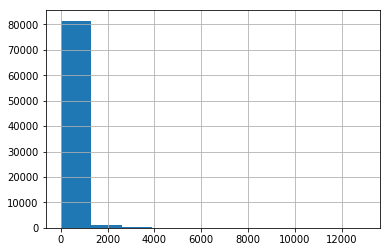

In [21]:
dflist['price'].hist();

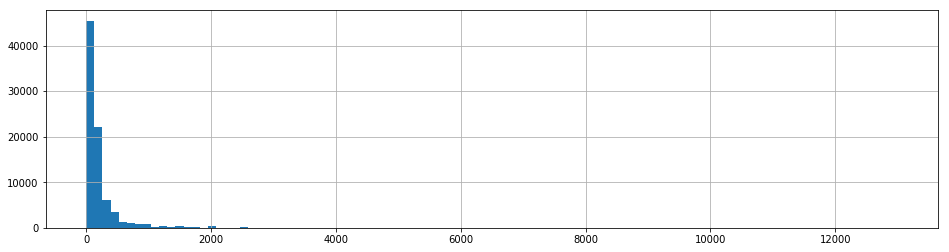

In [22]:
dflist['price'].hist(bins=100, figsize=(16,4));

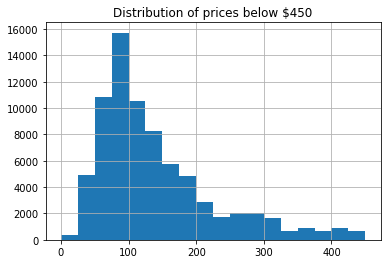

In [23]:
dflist['price'].hist(bins=[0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450])
plt.title('Distribution of prices below $450');

In [24]:
# look at outliers (low)

dflist[dflist['price'] == 0]

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,transit,weekly_price,xl_picture_url,zipcode,year,year_2015,year_2018,q_2,q_3,q_4
3832,"Front and back screened-in porches, yard, Wifi...",5,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",24,340,48,68,1.5,Real Bed,2.0,...,Takoma Metro Station 4 blocks away.,NaN,https://a0.muscache.com/im/pictures/e2ae0b5e-0...,20012,2017,0,0,1,0,0
7787,"You will have access to the backyard, basement...",2,"{TV,Internet,""Wireless Internet"",""Air conditio...",24,359,54,84,1.0,Real Bed,1.0,...,Again as mentioned above there is two trains s...,NaN,https://a0.muscache.com/im/pictures/0c0630b4-0...,other,2017,0,0,1,0,0
6335,"You will have access to the backyard, basement...",2,"{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",0,0,0,0,1.0,Real Bed,1.0,...,Again as mentioned above there is two trains s...,NaN,NaN,other,2018,0,1,1,0,0
7281,You will have access to the living room and en...,5,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",0,99,0,0,2.0,Real Bed,2.0,...,If coming by metro from DCA Airport take the y...,NaN,NaN,20009,2018,0,1,1,0,0
7283,Shared bathroom,2,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",0,13,0,13,1.0,Real Bed,1.0,...,We are located in between the Mt Vernon Square...,NaN,NaN,20001,2018,0,1,1,0,0
7599,At the moment guests only have access to the r...,2,"{TV,""Air conditioning"",Heating,Essentials,Sham...",10,50,23,50,1.0,Real Bed,1.0,...,"House is 0.9 miles from tenlytown metro, rough...",NaN,NaN,20016,2018,0,1,1,0,0
8152,"The room has a lock on the door, plenty of spa...",3,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,Gym,E...",29,364,59,89,1.0,Real Bed,1.0,...,The best way to get around is by train or taxi...,NaN,NaN,20011,2018,0,1,1,0,0
8281,"The room has a lock on the door, plenty of spa...",3,"{TV,""Cable TV"",Wifi,""Air conditioning"",Pool,Ki...",15,350,45,75,1.0,Real Bed,1.0,...,The best way to get around is by train or taxi...,NaN,NaN,20011,2018,0,1,1,0,0
7165,At the moment guests only have access to the r...,2,"{TV,""Air conditioning"",Heating,Essentials,Sham...",4,49,24,49,1.0,Real Bed,1.0,...,"House is 0.9 miles from tenlytown metro, rough...",NaN,NaN,20016,2018,0,1,1,0,0
6961,At the moment guests only have access to the r...,2,"{TV,""Air conditioning"",Heating,Essentials,Sham...",8,61,31,61,1.0,Real Bed,1.0,...,"House is 0.9 miles from tenlytown metro, rough...",NaN,NaN,20016,2018,0,1,0,1,0


In [25]:
# look at outliers (high)

dflist[dflist['price'] > 5000].sort_values(by='price', ascending=False)

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,transit,weekly_price,xl_picture_url,zipcode,year,year_2015,year_2018,q_2,q_3,q_4
8650,NaN,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",18,78,48,78,1.0,Real Bed,2.0,...,NaN,NaN,NaN,20024,2018,0,1,0,1,0
8653,NaN,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",30,90,60,90,1.0,Real Bed,2.0,...,NaN,NaN,NaN,20024,2018,0,1,0,1,0
8275,NaN,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",30,90,60,90,1.0,Real Bed,2.0,...,NaN,NaN,NaN,20024,2018,0,1,0,0,1
8445,NaN,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",30,90,60,90,1.0,Real Bed,2.0,...,NaN,NaN,NaN,20024,2018,0,1,0,1,0
8195,NaN,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",30,90,60,90,1.0,Real Bed,2.0,...,NaN,NaN,NaN,20024,2018,0,1,0,0,1
3596,The home has a staff apartment and catering ki...,8,"{TV,Wifi,""Air conditioning"",Kitchen,""Indoor fi...",23,358,53,83,6.5,Real Bed,4.0,...,NaN,NaN,NaN,20007,2018,0,1,0,1,0
3659,The home has a staff apartment and catering ki...,8,"{TV,Wifi,""Air conditioning"",Kitchen,""Indoor fi...",23,358,53,83,6.5,Real Bed,4.0,...,NaN,NaN,NaN,20007,2018,0,1,1,0,0
3487,The home has a staff apartment and catering ki...,8,"{TV,Wifi,""Air conditioning"",Kitchen,""Indoor fi...",23,358,53,83,6.5,Real Bed,4.0,...,NaN,NaN,NaN,20007,2018,0,1,0,0,1
3499,The home has a staff apartment and catering ki...,8,"{TV,Wifi,""Air conditioning"",Kitchen,""Indoor fi...",23,358,53,83,6.5,Real Bed,4.0,...,NaN,NaN,NaN,20007,2018,0,1,0,0,1
3547,The home has a staff apartment and catering ki...,8,"{TV,Wifi,""Air conditioning"",Kitchen,""Indoor fi...",23,358,53,83,6.5,Real Bed,4.0,...,NaN,NaN,NaN,20007,2018,0,1,0,1,0


### EDA: correlation heatmaps for numeric variables

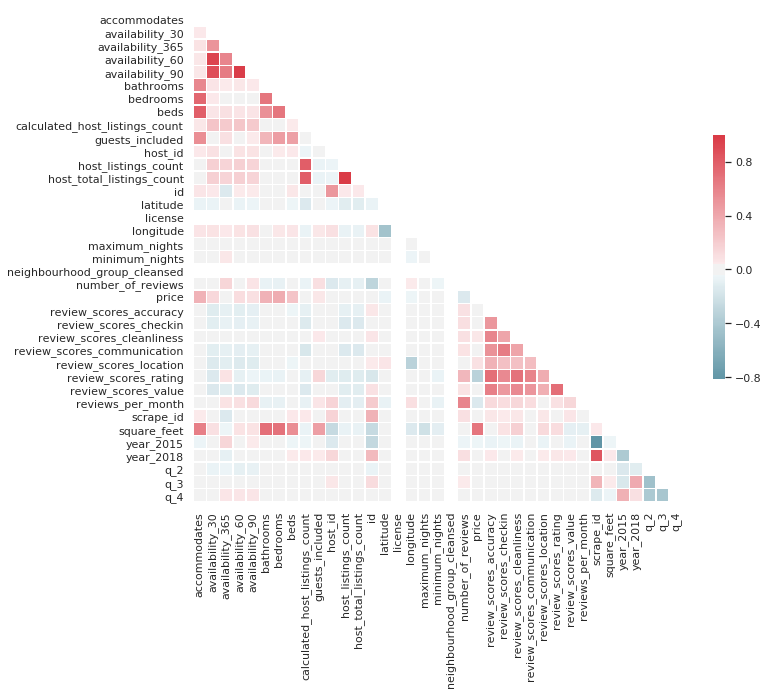

In [26]:
# ref: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set(style="white")

# Compute the correlation matrix
corr = dflist.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, #vmax=.3, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

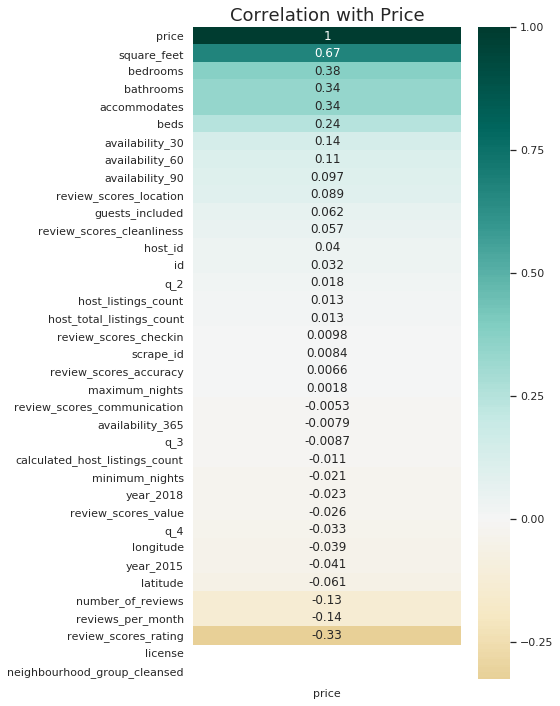

In [27]:
plt.figure(figsize=(6,12))
plt.title('Correlation with Price', fontsize=18)
sns.heatmap(dflist.corr()[['price']].sort_values(by='price', ascending=False), cmap="BrBG", center=0, annot=True);

### Data prep for linear regression

In [28]:
X = dflist[features].dropna()
y = X['price']
X = X.drop(columns='price')

X = pd.get_dummies(X, columns=features_cat, drop_first=True)
X.head()

,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,availability_365,number_of_reviews,review_scores_rating,host_is_superhost_t,"neighbourhood_cleansed_Brookland, Brentwood, Langdon",...,property_type_Serviced apartment,property_type_Townhouse,property_type_other,room_type_Private room,room_type_Shared room,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,18,4,1.0,1.0,2.0,283,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6,3.0,3.0,3.0,343,65,94.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,2,1.0,1.0,1.0,365,0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,4,1.0,1.0,1.0,351,0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,1,4,1.0,2.0,4.0,361,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Baseline regression model

In [31]:
# Create Dummy Regression that always predicts the mean value of target
# ref: https://chrisalbon.com/machine_learning/model_evaluation/create_baseline_regression_model/

# Create a dummy regressor
dummy_mean = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy_mean.fit(X_train_sc, y_train)

# Get R-squared (coefficient of determination)
print('baseline R^2:', dummy_mean.score(X_test_sc, y_test))

# get baseline RMSE (root mean squared error)
y_pred = dummy_mean.predict(X_test_sc)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('baseline RMSE:', rmse)

# get baseline MAE (mean absolute error)
mae = mean_absolute_error(y_test, y_pred)
print('baseline MAE:', mae)

baseline R^2: -3.734447825243237e-05
baseline RMSE: 363.70725971896525
baseline MAE: 170.73469224544976


### Model 01: Linear regression

In [32]:
# fit model
model = LinearRegression()
model.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
# Evaluate model

print('train R^2:', model.score(X_train_sc, y_train))
print('test R^2:', model.score(X_test_sc, y_test))
print('')

# compare train & test RMSE (root mean squared error)

y_pred_train = model.predict(X_train_sc)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)

y_pred_test = model.predict(X_test_sc)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print('train RMSE:', train_rmse)
print('test RMSE:', test_rmse)
print('')

# compare train & test MAE (mean absolute error)

y_pred_train = model.predict(X_train_sc)
train_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_test = model.predict(X_test_sc)
test_mae = mean_absolute_error(y_test, y_pred_test)

print('train MAE:', train_mae)
print('test MAE:', test_mae)

train R^2: 0.29154075644475186
test R^2: 0.3059459610704536

train RMSE: 309.67953407264605
test RMSE: 302.99851752186004

train MAE: 142.13779530770688
test MAE: 141.2101780173359


### Model 02: Lasso

In [34]:
# Instantiate model
lasso_model = LassoCV(cv=3)

# Fit model using best alpha
lasso_model = lasso_model.fit(X_train_sc, y_train)

# optimal value of alpha
lasso_model.alpha_

0.13756591943453098

In [35]:
# Evaluate model

print('train R^2:', lasso_model.score(X_train_sc, y_train))
print('test R^2:', lasso_model.score(X_test_sc, y_test))
print('')

# compare train & test RMSE (root mean squared error)

y_pred_train = lasso_model.predict(X_train_sc)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)

y_pred_test = lasso_model.predict(X_test_sc)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print('train RMSE:', train_rmse)
print('test RMSE:', test_rmse)
print('')

# compare train & test MAE (mean absolute error)

y_pred_train = lasso_model.predict(X_train_sc)
train_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_test = lasso_model.predict(X_test_sc)
test_mae = mean_absolute_error(y_test, y_pred_test)

print('train MAE:', train_mae)
print('test MAE:', test_mae)

train R^2: 0.2913268961273844
test R^2: 0.3057636322784849

train RMSE: 309.7262715291581
test RMSE: 303.03831393740666

train MAE: 141.83063547480927
test MAE: 140.87362188475439


In [36]:
# look at coefficients

lasso_coefs = pd.DataFrame(data=lasso_model.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs['abs_coef'] = np.abs(lasso_coefs['coef'])
lasso_coefs.sort_values('abs_coef', ascending=False)

,coef,abs_coef
review_scores_rating,-104.019572,104.019572
bedrooms,61.114387,61.114387
accommodates,55.570975,55.570975
bathrooms,53.579889,53.579889
room_type_Private room,-30.140126,30.140126
calculated_host_listings_count,-30.051785,30.051785
"neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",28.759601,28.759601
beds,-28.391245,28.391245
"neighbourhood_cleansed_Capitol Hill, Lincoln Park",26.887614,26.887614
"neighbourhood_cleansed_Shaw, Logan Circle",24.780547,24.780547


In [37]:
# look at zero coefficients

lasso_coefs[lasso_coefs['abs_coef'] == 0]

,coef,abs_coef
"neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View",-0.0,0.0
zipcode_20012,-0.0,0.0
zipcode_20020,-0.0,0.0
zipcode_20037,-0.0,0.0


### Data prep for model 03

In [38]:
features.extend(['year_2015', 'year_2018', 'q_2', 'q_3', 'q_4'])
X = dflist[features].dropna()
y = X['price']
X = X.drop(columns='price')

X = pd.get_dummies(X, columns=features_cat, drop_first=True)
X.head()

,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,availability_365,number_of_reviews,review_scores_rating,year_2015,year_2018,...,property_type_Serviced apartment,property_type_Townhouse,property_type_other,room_type_Private room,room_type_Shared room,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,18,4,1.0,1.0,2.0,283,0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6,3.0,3.0,3.0,343,65,94.0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,2,1.0,1.0,1.0,365,0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,4,1.0,1.0,1.0,351,0,0.0,1,0,...,0,1,0,0,0,0,0,0,0,0
5,1,4,1.0,2.0,4.0,361,0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Model 03: Lasso (with time features)

In [41]:
# Instantiate model
lasso_model = LassoCV(cv=3)

# Fit model using best alpha
lasso_model = lasso_model.fit(X_train_sc, y_train)

# optimal value of alpha
lasso_model.alpha_

0.13756591943453098

In [42]:
# Evaluate model

print('train R^2:', lasso_model.score(X_train_sc, y_train))
print('test R^2:', lasso_model.score(X_test_sc, y_test))
print('')

# compare train & test RMSE (root mean squared error)

y_pred_train = lasso_model.predict(X_train_sc)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)

y_pred_test = lasso_model.predict(X_test_sc)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print('train RMSE:', train_rmse)
print('test RMSE:', test_rmse)
print('')

# compare train & test MAE (mean absolute error)

y_pred_train = lasso_model.predict(X_train_sc)
train_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_test = lasso_model.predict(X_test_sc)
test_mae = mean_absolute_error(y_test, y_pred_test)

print('train MAE:', train_mae)
print('test MAE:', test_mae)

train R^2: 0.2932196794933575
test R^2: 0.3077388121176251

train RMSE: 309.31237356757293
test RMSE: 302.6069179879987

train MAE: 142.0145888783767
test MAE: 141.23183178730818


In [43]:
# look at coefficients

lasso_coefs = pd.DataFrame(data=lasso_model.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs['abs_coef'] = np.abs(lasso_coefs['coef'])
lasso_coefs.sort_values('abs_coef', ascending=False)

,coef,abs_coef
review_scores_rating,-103.541936,103.541936
bedrooms,61.014932,61.014932
accommodates,55.054687,55.054687
bathrooms,53.749027,53.749027
calculated_host_listings_count,-31.468333,31.468333
room_type_Private room,-30.035154,30.035154
"neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",28.739145,28.739145
beds,-28.511553,28.511553
"neighbourhood_cleansed_Capitol Hill, Lincoln Park",26.705855,26.705855
"neighbourhood_cleansed_Shaw, Logan Circle",24.784675,24.784675


In [44]:
# look at zero coefficients

lasso_coefs[lasso_coefs['abs_coef'] == 0]

,coef,abs_coef
q_3,-0.0,0.0
"neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View",-0.0,0.0
zipcode_20016,-0.0,0.0
zipcode_20020,-0.0,0.0
zipcode_20037,-0.0,0.0


### Data prep for model 04

In [45]:
X = dflist[features].dropna()
y = X['price']
X = X.drop(columns='price')

X = pd.get_dummies(X, columns=features_cat, drop_first=True)
X.head()

,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,availability_365,number_of_reviews,review_scores_rating,year_2015,year_2018,...,property_type_Serviced apartment,property_type_Townhouse,property_type_other,room_type_Private room,room_type_Shared room,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,18,4,1.0,1.0,2.0,283,0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6,3.0,3.0,3.0,343,65,94.0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,2,1.0,1.0,1.0,365,0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,4,1.0,1.0,1.0,351,0,0.0,1,0,...,0,1,0,0,0,0,0,0,0,0
5,1,4,1.0,2.0,4.0,361,0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [47]:
# to reduce total number of polynomial features:
# include interaction terms only (not squared terms) 
poly = PolynomialFeatures(interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [48]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train_poly)
X_test_sc = ss.transform(X_test_poly)

### Model 04: Lasso (with polynomial features)

In [49]:
# Instantiate model
lasso_model = LassoCV(cv=3)

# Fit model using best alpha
lasso_model = lasso_model.fit(X_train_sc, y_train)

# optimal value of alpha
lasso_model.alpha_

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. 

0.13933611330172846

In [50]:
# Evaluate model

print('train R^2:', lasso_model.score(X_train_sc, y_train))
print('test R^2:', lasso_model.score(X_test_sc, y_test))
print('')

# compare train & test RMSE (root mean squared error)

y_pred_train = lasso_model.predict(X_train_sc)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)

y_pred_test = lasso_model.predict(X_test_sc)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print('train RMSE:', train_rmse)
print('test RMSE:', test_rmse)
print('')

# compare train & test MAE (mean absolute error)

y_pred_train = lasso_model.predict(X_train_sc)
train_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_test = lasso_model.predict(X_test_sc)
test_mae = mean_absolute_error(y_test, y_pred_test)

print('train MAE:', train_mae)
print('test MAE:', test_mae)

train R^2: 0.474581076671873
test R^2: 0.4849997245113851

train RMSE: 266.69073262487814
test RMSE: 261.00425736753783

train MAE: 118.46591610939385
test MAE: 121.60478498080356


In [51]:
# look at coefficients

lasso_coefs = pd.DataFrame(poly.get_feature_names(X_train.columns))
lasso_coefs['coef'] = lasso_model.coef_
lasso_coefs['abs_coef'] = np.abs(lasso_coefs['coef'])
lasso_coefs.sort_values('abs_coef', ascending=False)

,0,coef,abs_coef
2,accommodates,120.585354,120.585354
167,accommodates review_scores_rating,-114.632033,114.632033
286,bathrooms zipcode_20007,84.229379,84.229379
626,review_scores_rating host_is_superhost_t,83.072543,83.072543
14,host_is_superhost_t,-75.466774,75.466774
319,bedrooms beds,-75.172428,75.172428
245,bathrooms review_scores_rating,-74.581892,74.581892
163,accommodates bedrooms,70.371507,70.371507
269,bathrooms neighbourhood_cleansed_Kalorama Heig...,69.623879,69.623879
276,bathrooms neighbourhood_cleansed_Spring Valley...,68.102101,68.102101


In [52]:
# look at zero coefficients

lasso_coefs[lasso_coefs['abs_coef'] == 0]

,0,coef,abs_coef
0,1,0.0,0.0
5,beds,-0.0,0.0
7,number_of_reviews,-0.0,0.0
9,year_2015,-0.0,0.0
11,q_2,-0.0,0.0
12,q_3,0.0,0.0
13,q_4,-0.0,0.0
15,"neighbourhood_cleansed_Brookland, Brentwood, L...",0.0,0.0
16,"neighbourhood_cleansed_Capitol Hill, Lincoln Park",0.0,0.0
17,"neighbourhood_cleansed_Capitol View, Marshall ...",0.0,0.0
